In [1]:
# -*- coding: utf-8 -*-
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

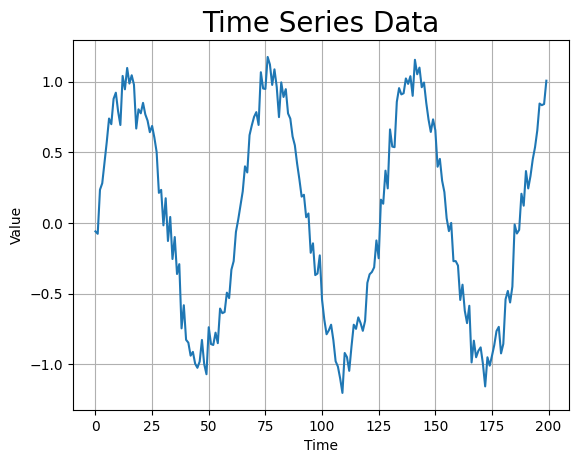

In [2]:
# 生成時間序列資料（AR 模擬）
data = np.sin(np.linspace(0, 20, 200)) + np.random.normal(0, 0.1, 200)
#plot data
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.grid(True)
plt.show()

In [3]:
#產生特徵(AR window)
def create_dataset(data, window_size=5):
    X, Y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        Y.append(data[i+window_size])
    return np.array(X), np.array(Y)

In [4]:
window_size = 10
X,y = create_dataset(data,window_size=window_size)
print(f"X.shape, y.shape = {X.shape}, {y.shape}")

X.shape, y.shape = (190, 10), (190,)


## 模型架構
<img src="dense_demo.png" width="400">

In [5]:
#模型建立
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

#訓練
ts = time.time()
history = model.fit(X, y, epochs=100, batch_size=32, verbose=1)
print("time cost: %.2f" % (time.time()-ts))

Epoch 1/100


c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5818  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3498 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2195 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1598 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1372 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1227 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1103 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1019 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0825 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0709 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0670 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 
Epoch 16/100
6/6 ━━━━━━━━━━━━━

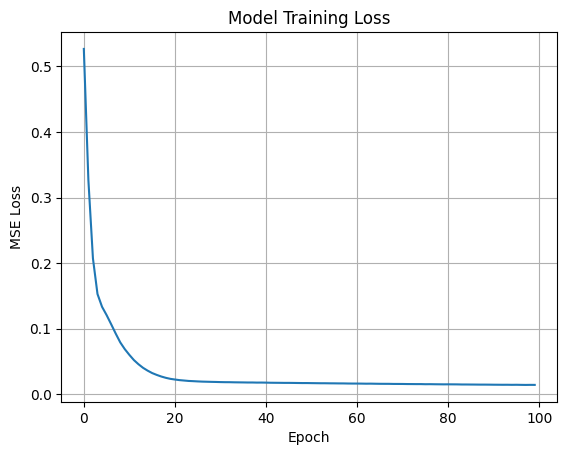

In [ ]:
#繪製loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [7]:
# prediction
last_window = data[-window_size:]
preds = []

for _ in range(100):
    input_data = last_window[-window_size:].reshape(1, -1)
    next_val = model.predict(input_data,verbose=0)[0,0]
    preds.append(next_val)
    last_window = np.append(last_window, next_val)

In [8]:
type(next_val)

numpy.float32

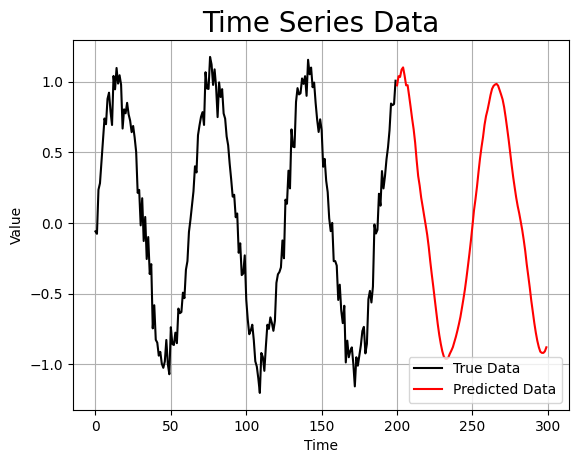

In [ ]:
# 繪製模擬資料+預測資料
# 迴歸模型普遍現象: 誤差逐步累積
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(data)),data, label='True Data',c='black')
plt.plot(range(len(data),len(data)+len(preds)),preds, label='Predicted Data',c='red')
plt.legend()
plt.show()

In [ ]:
# 儲存模型
model_path = './checkpoints/ar_model_0520.keras'
model.save(model_path)

In [ ]:
# 非量化轉換(保留原模型大小)
# 直接從keras model轉換，亦可以從training graph傳入參數
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_no_quantized = converter.convert()

with open("./checkpoints/ar_model_no_quantized.tflite", "wb") as f:
    f.write(tflite_model_no_quantized)

INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpiuq5jkgz\assets


INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpiuq5jkgz\assets


Saved artifact at 'C:\Users\Davidgu\AppData\Local\Temp\tmpiuq5jkgz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2086477325584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477330384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477329232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477328080: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [12]:
#量化轉換(減少模型大小提升效能)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quantized = converter.convert()
with open("./checkpoints/ar_model_quantized.tflite", "wb") as f:
    f.write(tflite_model_quantized)

INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpxi32s0mb\assets


INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmpxi32s0mb\assets


Saved artifact at 'C:\Users\Davidgu\AppData\Local\Temp\tmpxi32s0mb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2086477325584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477330384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477329232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2086477328080: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [13]:
#讀取模型比較inference 
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter


interpreter_no_quantized = load_tflite_model("./checkpoints/ar_model_no_quantized.tflite")
interpreter_quantized = load_tflite_model("./checkpoints/ar_model_quantized.tflite")


c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [14]:
input_details_no_quantized = interpreter_no_quantized.get_input_details()
output_details_no_quantized = interpreter_no_quantized.get_output_details()

input_details_quantized = interpreter_quantized.get_input_details()
output_details_quantized = interpreter_quantized.get_output_details()


In [15]:
input_details_no_quantized

[{'name': 'serving_default_keras_tensor:0',
  'index': 0,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [16]:
output_details_no_quantized

[{'name': 'StatefulPartitionedCall_1:0',
  'index': 6,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [17]:
input_data = last_window[-window_size:].reshape(1, -1).astype(np.float32)
#Inference for 未量化(float32)
interpreter_no_quantized.set_tensor(input_details_no_quantized[0]['index'], input_data)
interpreter_no_quantized.invoke()
print(interpreter_no_quantized.get_tensor(output_details_no_quantized[0]['index']))

#Inference for 量化
interpreter_quantized.set_tensor(input_details_quantized[0]['index'], input_data)
interpreter_quantized.invoke()
print(interpreter_quantized.get_tensor(output_details_quantized[0]['index']))

[[-0.8614601]]
[[-0.8614601]]


In [18]:
print(type(interpreter_quantized.get_tensor(output_details_quantized[0]['index'])))

<class 'numpy.ndarray'>


In [19]:
#定義一個推論function
def predict_with_interpreter(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])

In [20]:
# for quantized model
last_window_quantized = data[-window_size:]
preds_quantized = []
preds_inference_time_quantized = []
for _ in range(100):
    input_data = last_window_quantized[-window_size:].reshape(1, -1).astype(np.float32)
    ts=time.time()
    next_val = predict_with_interpreter(interpreter_quantized, input_data)[0,0]
    te=time.time()
    preds_quantized.append(next_val)
    preds_inference_time_quantized.append(te-ts)
    last_window_quantized = np.append(last_window_quantized, next_val)

# for no quantized model
last_window_no_quantized = data[-window_size:]
preds_no_quantized = []
preds_inference_time_no_quantized = []
for _ in range(100):
    input_data = last_window_no_quantized[-window_size:].reshape(1, -1).astype(np.float32)
    ts=time.time()
    next_val = predict_with_interpreter(interpreter_no_quantized, input_data)[0,0]
    te=time.time()
    preds_inference_time_no_quantized.append(te-ts)
    preds_no_quantized.append(next_val)
    last_window_no_quantized = np.append(last_window_no_quantized, next_val)

In [21]:
print(f"Average inference time for quantized model: {np.mean(preds_inference_time_quantized[-50:])}")
print(f"Average inference time for no quantized model: {np.mean(preds_inference_time_no_quantized[-50:])}")

Average inference time for quantized model: 0.0
Average inference time for no quantized model: 1.9812583923339842e-05


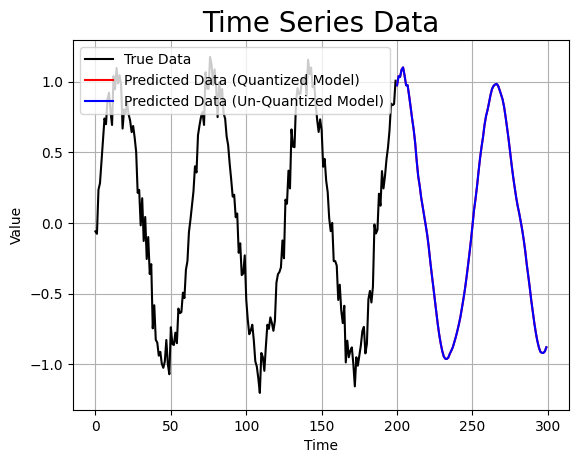

In [22]:
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(data)),data, label='True Data',c='black')
plt.plot(range(len(data),len(data)+len(preds_quantized)),preds_quantized, label='Predicted Data (Quantized Model)',c='red')
plt.plot(range(len(data),len(data)+len(preds_no_quantized)),preds_no_quantized, label='Predicted Data (Un-Quantized Model)',c='blue')
plt.legend(loc='upper left', fontsize=10)
plt.show()